**Excersize 3:**

**1.1 PCA and t-SNE extracted features visualization after training on MNIST**

# Initialization of project folders and data

In [ ]:
import copy
import datetime
import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import re
import seaborn as sns
import shutil
import subprocess
import tabulate
import tarfile
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import urllib.request
import zipfile
from copy import deepcopy
from google.colab import drive
from matplotlib.ticker import FuncFormatter, LogLocator, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from torchvision.datasets import CIFAR10, MNIST
from tqdm.auto import tqdm
from tabulate import tabulate
#%load_ext tensorboard

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Set the project folder
mount_point = '/content/drive/'
data_folder = '/content/data'

if not os.path.exists(mount_point):
    drive.mount(mount_point)
else:
    print(f"Drive is already mounted at {mount_point}")

os.chdir(os.path.join(mount_point))

# Delete existing data folders
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)

if os.path.exists(os.path.join(mount_point,'/cifar-10')):
    shutil.rmtree(os.path.join(mount_point,'/cifar-10'))

if os.path.exists(os.path.join(mount_point,'/cifar-10-batches-py')):
    shutil.rmtree(os.path.join(mount_point,'/cifar-10-batches-py'))

# Create the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Create the 'project' folder on Google Drive if it doesn't exist
project_folder = os.path.join(mount_point, 'MyDrive/D7047E/MNIST/')
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f"\nProject folder created at {project_folder}")

# Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy')
if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)
    print(f"\naccuracy folder created at {accuracy_folder}")

# Create the 'softmax' folder in the project folder on Google Drive if it doesn't exist
softmax_folder = os.path.join(mount_point, project_folder, 'softmax')
if not os.path.exists(softmax_folder):
    os.makedirs(softmax_folder)
    print(f"\nsoftmax folder created at {softmax_folder}")

# Create the 'logs' folder in the project folder on Google Drive if it doesn't exist
logs_folder = os.path.join(mount_point, project_folder, 'logs')
if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)
    print(f"\nlogs folder created at {logs_folder}")

# Create the 'checkpoints' folder in the project folder on Google Drive if it doesn't exist
checkpoint_folder = os.path.join(mount_point, project_folder, 'checkpoint')
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
    print(f"\nCheckpoints folder created at {checkpoint_folder}")

os.chdir('/content/')

if not os.path.exists(data_folder):
    num_files = 0
else:
    num_files = 0
    for root, dirs, files in os.walk(data_folder):
        num_files += len(files)

print(f'\nThere are {num_files} files in the destination folder: {data_folder}\n')

# Download and extract CIFAR10 dataset
class customCIFAR10(CIFAR10):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        img_path = self.data[index]
        return img, target, img_path

# Download and extract MNIST dataset
class customMNIST(MNIST):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        img_path = self.data[index]
        return img, target, img_path

# Data transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'valid': transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'test': transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'visualization': transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
}

# Download and extract MNIST datasets
trainset = datasets.MNIST(root=data_folder, train=True, download=True, transform=transform['train'])
testset  = customMNIST(root=data_folder, train=False, download=True, transform=transform['test'])

# Rename the extracted folder from cifar-10-batches-py to cifar-10
if os.path.exists(os.path.join(data_folder, 'cifar-10-batches-py')):
    os.rename(os.path.join(data_folder, 'cifar-10-batches-py'), os.path.join(data_folder, 'cifar-10'))

# Remove the downloaded tar.gz file
src_file = 'cifar-10-python.tar.gz'
if os.path.exists(os.path.join(data_folder, src_file)):
    os.remove(os.path.join(data_folder, src_file))

print("\nMNIST dataset downloaded and extracted successfully.")

# Split trainset into validation and training using stratified sampling

trainset.targets = np.array(trainset.targets)
train_idx, val_idx = train_test_split(np.arange(len(trainset.targets)),
                                  test_size=0.2,
                                  stratify=trainset.targets,
                                  random_state=42)

# Verify splits are disjoint
assert set(train_idx).isdisjoint(set(val_idx)), "There are common elements between the training and validation splits"

# Create train_set and val_set from trainset
train_set = Subset(trainset, train_idx)
val_set = Subset(trainset, val_idx)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'valid': val_loader, 'test': test_loader}

# Class labels for CIFAR-10 dataset
#class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

# Class labels for MNIST & SVHN dataset
class_names = list(range(10))

# Save metrics to pickle files
pickle_files = [
    "all_train_accuracies.pickle",
    "all_train_losses.pickle",
    "all_val_accuracies.pickle",
    "all_val_losses.pickle",
    "all_learning_rates.pickle",]

Drive is already mounted at /content/drive/

There are 0 files in the destination folder: /content/data



100%|██████████| 9912422/9912422 [00:00<00:00, 92316616.14it/s]


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46554840.06it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26498480.40it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11810619.20it/s]


Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 93857779.38it/s]


Extracting /content/data/customMNIST/raw/train-images-idx3-ubyte.gz to /content/data/customMNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24343989.92it/s]

Extracting /content/data/customMNIST/raw/train-labels-idx1-ubyte.gz to /content/data/customMNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26308468.97it/s]


Extracting /content/data/customMNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/customMNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4966248.38it/s]


Extracting /content/data/customMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/customMNIST/raw


MNIST dataset downloaded and extracted successfully.


# ConvNet model and functions

**conv1**: a 2D convolutional layer with 1 input channel, 32 output channels, and a kernel size of 3x3 with padding of 1.

**bn1**: a batch normalization layer for conv1.

**conv2**: a 2D convolutional layer with 32 input channels, 32 output channels, and a kernel size of 3x3 with padding of 1.

**bn2**: a batch normalization layer for conv2.

**pool1**: a max pooling layer with a kernel size of 2x2 and stride of 2.

**dropout1**: a dropout layer that randomly zeroes out 25% of the elements of the input tensor.

**conv3**: a 2D convolutional layer with 32 input channels, 64 output channels, and a kernel size of 3x3 with padding of 1.

**bn3**: a batch normalization layer for conv3.

**conv4**: a 2D convolutional layer with 64 input channels, 64 output channels, and a kernel size of 3x3 with padding of 1.

**bn4**: a batch normalization layer for conv4.

**pool2**: a max pooling layer with a kernel size of 2x2 and stride of 2.

**dropout2**: a dropout layer that randomly zeroes out 25% of the elements of the input tensor.

**fc1**: a fully connected layer with 6488 input features and 512 output features.

**bn5**: a batch normalization layer for fc1.

**dropout3**: a dropout layer that randomly zeroes out 50% of the elements of the input tensor.

**fc2**: a fully connected layer with 512 input features and 10 output features (one for each class).

**activation_function**: an activation function used in all convolutional and fully connected layers.
*********************
The network takes a 1-channel grayscale image as input and outputs a vector of size 10 with a score for each class. The input image is first passed through two sets of convolutional and pooling layers, and then through two fully connected layers.

Batch normalization is applied after each convolutional and fully connected layer, and dropout is applied after each max pooling and fully connected layer.

The ReLU activation function is used throughout the network.

The input image is a grayscale image with a shape of (1, 28, 28) (one channel,
28 pixels width, and 28 pixels height).

The image is fed into the first convolutional layer self.conv1, which has a kernel size of 3 and 32 output channels. This produces an output tensor with a shape of (32, 28, 28).

The output tensor from the first convolutional layer is passed through the batch normalization layer self.bn1.

The output of self.bn1 is then passed through the activation function self.activation_function, which is a ReLU function.

The output of the activation function is passed through the second convolutional layer self.conv2, which has the same kernel size and output channels as self.conv1. This produces an output tensor with the same shape as the output tensor of self.conv1.

The output tensor from the second convolutional layer is passed through the batch normalization layer self.bn2.

The output of self.bn2 is then passed through the same activation function self.activation_function.

The output of the activation function is passed through the max pooling layer self.pool1, which performs a 2x2 pooling operation with a stride of 2. This reduces the spatial size of the tensor by a factor of 2, resulting in an output tensor with a shape of (32, 14, 14).

The output tensor from self.pool1 is passed through the dropout layer self.dropout1, which randomly zeros out 25% of the tensor elements.

The output tensor from self.dropout1 is passed through the third convolutional layer self.conv3, which has a kernel size of 3 and 64 output channels. This produces an output tensor with a shape of (64, 14, 14).

The output tensor from the third convolutional layer is passed through the batch normalization layer self.bn3.

The output of self.bn3 is then passed through the same activation function self.activation_function.

The output of the activation function is passed through the fourth convolutional layer self.conv4, which has the same kernel size and output channels as self.conv3. This produces an output tensor with the same shape as the output tensor of self.conv3.

The output tensor from the fourth convolutional layer is passed through the batch normalization layer self.bn4.

The output of self.bn4 is then passed through the same activation function self.activation_function.

The output of the activation function is passed through the max pooling layer self.pool2, which performs the same operation as self.pool1 but on the output of self.conv4. This reduces the spatial size of the tensor by a factor of 2, resulting in an output tensor with a shape of (64, 7, 7).

The output tensor from self.pool2 is passed through the dropout layer self.dropout2, which randomly zeros out 25% of the tensor elements.

The output tensor from self.dropout2 is flattened into a 1D tensor using the view method with -1 as the first argument, which means "infer the size of this dimension". The resulting tensor has a shape of (batch_size, 64 * 8 * 8).
This 1D tensor is the final output of the `ConvNet` model

In [ ]:
# Define the custom CNN architecture class
class ConvNet(nn.Module):
    def __init__(self, activation_function=nn.ReLU()):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #modified for greyscale
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

        self.activation_function = activation_function

    def forward(self, x):
        x = self.bn1(self.activation_function(self.conv1(x)))
        x = self.bn2(self.activation_function(self.conv2(x)))
        x = self.dropout1(self.pool1(x))

        x = self.bn3(self.activation_function(self.conv3(x)))
        x = self.bn4(self.activation_function(self.conv4(x)))
        x = self.dropout2(self.pool2(x))

        x = x.view(-1, 64 * 8 * 8)
        x = self.bn5(self.activation_function(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x

def convert_to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]


def save_dicts_to_files(file_prefix, data_dicts, accuracy_folder):
    for data_dict, file in zip(data_dicts, pickle_files):
        file_name = os.path.join(accuracy_folder, f"{file[:-7]}{file_prefix}.pickle")
        with open(file_name, "wb") as handle:
            converted_dict = {k: [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in v] for k, v in data_dict.items()}
            pickle.dump(converted_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_dicts_from_files(pickle_files, accuracy_folder):
    loaded_dicts = []
    for file in pickle_files:
        file_name = os.path.join(accuracy_folder, file)
        if not os.path.exists(file_name):
            print(f"\nError: {file_name} not found\n")
            return None
        with open(file_name, "rb") as handle:
            data_dict = pickle.load(handle)

            # Convert to CPU
            data_dict_cpu = {k: convert_to_cpu(v) for k, v in data_dict.items()}
            loaded_dicts.append(data_dict_cpu)
    return loaded_dicts


def activation_name(activation_func):
    name = str(activation_func)
    if "Tanh" in name:
        return "Tanh"
    elif "LeakyReLU" in name:
        return "LeakyReLU"
    elif ".ReLU" in name:
        return "ReLU"
    else:
        return name


def latest_checkpoint(checkpoint_folder):
    checkpoint_files = [f for f in os.listdir(checkpoint_folder) if f.endswith('.pth')]
    if not checkpoint_files:
        return None

    # Extract epoch numbers from file names
    epoch_numbers = [int(re.search(r'e(\d+)', f).group(1)) for f in checkpoint_files]

    # Find the file with the highest epoch number
    latest_epoch = max(epoch_numbers)
    latest_checkpoint_file = f'model_checkpoint_e{latest_epoch}.pth'

    return os.path.join(checkpoint_folder, latest_checkpoint_file)

In [ ]:
def train_and_evaluate(
    activation_functions,
    best_model_params,
    best_val_acc,
    criterion,
    early_stopping_patience,
    epochs,
    freeze_layers,
    layers,
    lr,
    lr_patience,
    metric,
    model_list,
    optimizers,
    saving_frequency,
    tensorboard_active,
    tensorboard_log
):

    for model_dict in model_list:

        model_name = model_dict["name"]
        model_class = model_dict["model"]

        best_val_acc = 0.0
        best_model_params = None

        # Initialize dictionaries to store losses and accuracies for each hyperparameter
        all_train_losses = {}
        all_train_accuracies = {}
        all_val_losses = {}
        all_val_accuracies = {}
        all_learning_rates = {}

        data_dicts = [all_train_accuracies, all_train_losses, all_val_accuracies, all_val_losses, all_learning_rates]

        best_model = None

        if tensorboard_active:
            %tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs')}
        if tensorboard_log:
            writer = SummaryWriter(os.path.join(mount_point, project_folder, 'logs', f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

        # Check for the latest checkpoint
        latest_checkpoint_path = latest_checkpoint(os.path.join(mount_point, project_folder, checkpoint_folder))

        start_epoch = 0
        if latest_checkpoint_path:
            user_input = input(f'Latest checkpoint found: {latest_checkpoint_path}. Do you want to resume training from this epoch? (y/n): ')

            if user_input.lower() == 'y':
                checkpoint = torch.load(latest_checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])

                # Get the optimizer type from the checkpoint
                optimizer_type = checkpoint['optimizer_type']

                # Initialize the optimizer using the optimizer type from the checkpoint
                optimizer = optimizers[optimizer_type](model.parameters(), lr=lr)
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_val_metric = checkpoint['best_val_metric']

        for opt in optimizers:

            for af in activation_functions:

                # Create a new model for each hyperparameter combination
                #num_features = model.classifier[6].in_features
                #model.classifier[6] = nn.Linear(num_features, len(class_names))
                model = model_class(activation_function=af()).to(device)

                # Freeze the layers
                if freeze_layers:
                    for name, param in model.named_parameters():
                        if layers not in name:
                            param.requires_grad = False

                #num_features = model.classifier[6].in_features # Modify the final layer
                #model.classifier[6] = nn.Linear(num_features, len(class_names))

                # Initialize the model and criterion
                initial_model_state = deepcopy(model.state_dict())
                initial_criterion = deepcopy(criterion)

                # Reset the model and criterion to their initial states
                #model.load_state_dict(deepcopy(initial_model_state))
                #criterion = deepcopy(initial_criterion)

                # Initialize the optimizer based on the selected type
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                print(f'\n\n\nTraining model {model_name} with learning rate: {lr}, optimizer: {opt} and activation function: {activation_name(af)} \n\n')

                # Initialize the learning rate scheduler
                scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=lr_patience, verbose=True)

                # Initialize lists to store loss and accuracy values
                train_losses = []
                train_accuracies = []
                val_losses = []
                val_accuracies = []
                learning_rates = []

                # Define early stopping parameters
                epochs_since_best = 0
                best_val_metric = None

                for epoch in range(epochs):
                    print(f'Epoch {epoch + 1}/{epochs}')
                    print('-' * 10)

                    hp = f'{model_name}_{lr}_{opt}_{activation_name(af)}_{epoch + 1}'

                    for phase in ['train', 'valid']:
                        if phase == 'train':
                            model.train()
                        else:
                            model.eval()

                        running_loss = 0.0
                        running_corrects = 0
                        num_samples = 0

                        progress_bar = tqdm(dataloaders[phase], desc=f'{phase} progress')
                        for inputs, labels in progress_bar:
                            inputs = inputs.to(device)
                            labels = labels.to(device)
                            optimizer.zero_grad()

                            # Forward pass and calculate the loss
                            with torch.set_grad_enabled(phase == 'train'):
                                outputs = model(inputs)
                                _, preds = torch.max(outputs, 1)
                                loss = criterion(outputs, labels)

                                # Backward pass and optimize the weights
                                if phase == 'train':
                                    loss.backward()
                                    optimizer.step()

                            running_loss += loss.item() * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            num_samples += inputs.size(0)

                            # Update the progress bar
                            progress_bar.set_postfix(loss=loss.item(), acc=running_corrects.double() / num_samples, refresh=True)

                        epoch_loss = running_loss / num_samples
                        epoch_acc = running_corrects.double() / num_samples

                        print(f'                      loss: {epoch_loss:.4f} accuracy: {epoch_acc * 100:.2f}%')

                        if phase == 'train':
                            train_losses.append(epoch_loss)
                            train_accuracies.append(epoch_acc)
                            learning_rates.append(lr)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Training loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Training accuracy_{hp}', epoch_acc, epoch)

                        else:
                            val_losses.append(epoch_loss)
                            val_accuracies.append(epoch_acc)
                            learning_rates.append(lr)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Validation loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Validation accuracy_{hp}', epoch_acc, epoch)

                            # Update the learning rate based on the validation accuracy
                            scheduler.step(epoch_acc)

                            # Save the current model state every 'x' epochs
                            if (epoch + 1) % saving_frequency == 0:
                                model_save_name = f'model_checkpoint_e{epoch+1}.pth'
                                model_save_path = os.path.join(mount_point, project_folder, checkpoint_folder, model_save_name)
                                print(f'\nSaving checkpoint for epoch {epoch+1} at {model_save_path}\n')
                                torch.save({
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'scheduler_state_dict': scheduler.state_dict(),
                                    'best_val_metric': best_val_metric,
                                    'optimizer_type': opt,
                                    'model_name': model_name
                                }, model_save_path)

                                checkpoint_paths = sorted(glob.glob(os.path.join(mount_point, project_folder, checkpoint_folder, '*.pth')), key=os.path.getctime)
                                if len(checkpoint_paths) > 2:
                                    for path in checkpoint_paths[:-2]:
                                        os.unlink(path)


                    # Choose the metric based on the 'metric' parameter
                    if metric == 'accuracy':
                        val_metric = epoch_acc
                        mode = 'max'
                    elif metric == 'loss':
                        val_metric = epoch_loss
                        mode = 'min'

                    # Update best validation metric and reset the counter
                    if best_val_metric is None or (mode == 'max' and val_metric > best_val_metric) or (mode == 'min' and val_metric < best_val_metric):
                        best_val_metric = val_metric
                        epochs_since_best = 0
                    else:
                        # Increment the counter if there is no improvement
                        epochs_since_best += 1

                    # Check if early stopping condition is met
                    if epochs_since_best >= early_stopping_patience:
                        print(f"\nEarly stopping triggered at epoch {epoch + 1}. No significant improvement in the validation metric for {early_stopping_patience} epochs.")
                        break


                # Save the losses and accuracies for the current setting
                all_train_losses[hp] = train_losses
                all_train_accuracies[hp] = train_accuracies
                all_val_losses[hp] = val_losses
                all_val_accuracies[hp] = val_accuracies
                all_learning_rates[hp] = learning_rates

                current_val_acc = max(val_accuracies)
                current_val_loss = min(val_losses)
                max_val_acc_epoch = val_accuracies.index(current_val_acc) + 1

                # Update the best model if the current validation accuracy is better
                if current_val_acc > best_val_acc:
                    best_val_acc = current_val_acc
                    rel_val_loss = current_val_loss
                    best_model = model
                    best_model_params = {
                        'lr': lr,
                        'af': {activation_name(af)},
                        'optimizer': opt,
                        'model_state': model.state_dict(),
                        'val_acc_epoch': max_val_acc_epoch  #save the epoch when the best validation accuracy is achieved
                    }

                    table = [["Model", model_name],
                            ["Best Validation Accuracy", f"{best_val_acc * 100:.2f}%"],
                            ["Validation Loss", f"{rel_val_loss:.4f}"],
                            ["Learning Rate", best_model_params["lr"]],
                            ["Optimizer", best_model_params["optimizer"]],
                            ["Activation", activation_name(af)],
                            ["Epoch", best_model_params["val_acc_epoch"]]]

                    print('\n', tabulate(table, tablefmt="simple"))

                    # Hyperparameter information
                    file_name_prefix = f'{model_name}_acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_{activation_name(af)}_epoch{best_model_params["val_acc_epoch"]}'

                    if best_model is not None:
                        # Save the best model with hyperparameter information
                        model_save_name = f'{file_name_prefix}.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model saved to {model_save_path}')

                        # Save the best model as 'best_model.pth'
                        # model_save_name = f'best_model.pth'
                        # model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        # torch.save(best_model_params['model_state'], model_save_path)
                        # print(f'\nBest model also saved as "best_model.pth"\n\n')


        # Close TensorBoard writer
        if tensorboard_log:
            writer.close()

        # Save with the prefix
        save_dicts_to_files(file_name_prefix, data_dicts, accuracy_folder)

        # Save to the base files
        save_dicts_to_files('', data_dicts, accuracy_folder)

    return best_model

In [ ]:
def plot_metrics():
    time.sleep(5) # eliminating errors related to the delays with Google Drive update after saving the metrics

    all_train_accuracies_cpu = {}
    all_train_losses_cpu = {}
    all_val_accuracies_cpu = {}
    all_val_losses_cpu = {}
    all_learning_rates_cpu = {}


    # Get a list of all directories in the project folder
    directories = [d for d in os.listdir(os.path.join(mount_point, project_folder)) if os.path.isdir(os.path.join(mount_point, project_folder, d))]

    # Get a list of accuracy folders (folders starting with 'accuracy')
    accuracy_folders = [d for d in directories if d.startswith('accuracy')]

    # Print numbered list of folders
    print("Folders available for processing:\n")
    for i, folder in enumerate(accuracy_folders):
        print(f"{i+1}. {folder}")

    # Ask which folders to process for plotting
    folders_to_process = []
    folder_indices = input("\nType the numbers of the folders you want to process (separated by commas), or press Enter to process all: ")
    if not folder_indices.strip():
        # process all folders
        folders_to_process = [os.path.join(mount_point, project_folder, folder) for folder in accuracy_folders]
    else:
        # process selected folders
        folder_indices = [int(i) for i in folder_indices.split(",")]
        for i in folder_indices:
            if i < 1 or i > len(accuracy_folders):
                print(f"\nInvalid folder number: {i}")
            elif not all(os.path.exists(os.path.join(mount_point, project_folder, accuracy_folders[i-1], file)) for file in pickle_files):
                print(f"\nFolder {accuracy_folders[i-1]} is incomplete and cannot be processed")
            else:
                folder_path = os.path.join(mount_point, project_folder, accuracy_folders[i-1])
                folders_to_process.append(folder_path)


    # Load the most recently created metrics dictionaries from files and convert them to CPU
    for folder in folders_to_process:

        if load_dicts_from_files(pickle_files, folder) is not None:

            merged_train_accuracies, merged_train_losses, merged_val_accuracies, merged_val_losses, merged_learning_rates = load_dicts_from_files(pickle_files, folder)

            all_train_accuracies_cpu.update(merged_train_accuracies)
            all_train_losses_cpu.update(merged_train_losses)
            all_val_accuracies_cpu.update(merged_val_accuracies)
            all_val_losses_cpu.update(merged_val_losses)
            all_learning_rates_cpu.update(merged_learning_rates)

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.5)

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]


    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        lr_history = all_learning_rates_cpu[setting]
        #epochs = np.arange(1, len(lr_history) + 1)
        epochs = np.linspace(1, len(lr_history), num=len(lr_history)) * 0.5  # modify x-scale
        axs_lr.plot(epochs, lr_history, linestyle='dotted', color=color, linewidth=0.75, alpha=0.5, label=label)

        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks

        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)
        axs_lr.legend(loc='upper right', fontsize='small')


    xticks = np.arange(1, len(all_train_accuracies_cpu.values()) + 1)

    max_train_acc_value = max([max(accuracies) for accuracies in all_train_accuracies_cpu.values()])
    max_train_acc_setting = max(all_train_accuracies_cpu, key=lambda key: max(all_train_accuracies_cpu[key]))
    max_train_acc_epoch = all_train_accuracies_cpu[max_train_acc_setting].index(max_train_acc_value) + 1

    max_val_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_val_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_val_acc_epoch = all_val_accuracies_cpu[max_val_acc_setting].index(max_val_acc_value) + 1

    min_train_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_train_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_train_loss_epoch = all_train_losses_cpu[min_train_loss_setting].index(min_train_loss_value) + 1

    min_val_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_val_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_val_loss_epoch = all_val_losses_cpu[min_val_loss_setting].index(min_val_loss_value) + 1

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        xticks = np.arange(1, len(accuracies) + 1)
        line = axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, color = color, label ='Learning Rate' if i == 0 else None)

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    #axs[0, 0].set_title("Training Accuracy")
    axs[0, 0].set_title(f"Training Accuracy\n\n (max: {max_train_acc_value:.4f} - {max_train_acc_setting} / e.{max_train_acc_epoch})\n")
    axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].legend(loc='best')

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        line = axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    #axs[0, 1].set_title("Training Loss")
    axs[0, 1].set_title(f"Training Loss\n\n (min: {min_train_loss_value:.4f} - {min_train_loss_setting} / e.{min_train_loss_epoch})\n")

    axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend(loc='best')

    for i, (setting, accuracies) in enumerate(all_val_accuracies_cpu.items()):
        line = axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy\n\n (max: {max_val_acc_value * 100:.2f}% - {max_val_acc_setting} / e.{max_val_acc_epoch})\n")
    axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 0].legend(loc='best')

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        line = axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss\n\n (min: {min_val_loss_value:.4f} - {min_val_loss_setting} / e.{min_val_loss_epoch})\n")
    axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend(loc='best')

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_train_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_value * 100:.2f}%')
    axs[0, 0].axvline(x=max_train_acc_epoch , linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_epoch}')

    axs[0, 1].axhline(y=min_train_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {min_train_loss_value}')
    axs[0, 1].axvline(x=min_train_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_train_loss_epoch}')

    axs[1, 0].axhline(y=max_val_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_val_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_val_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_val_acc_epoch}')

    axs[1, 1].axhline(y=min_val_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_val_loss_value:.4f}')
    axs[1, 1].axvline(x=min_val_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_val_loss_epoch}')

    #for ax in axs.flatten():
    #    ax.set_xlim(1, 50)

    plt.show()

In [ ]:
def evaluate_model(model_list, dataloaders, class_names, mount_point, project_folder, softmax_folder):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # List .pth files in the project folder
    project_path = os.path.join(mount_point, project_folder)
    pth_files = [f for f in os.listdir(project_path) if f.endswith('.pth')]

    # Print numbered list of .pth files
    print("Available models in a project folder:\n")
    for i, pth_file in enumerate(pth_files, start=1):
        print(f"{i}. {pth_file}")

    # Ask the user which file to process further
    selected_index = int(input("\nEnter the number corresponding to the file you want to process: ")) - 1
    selected_model_path = os.path.join(project_path, pth_files[selected_index])

    # Set the model to evaluation mode
    for model_dict in model_list:
        model_name = model_dict["name"]
        model_class = model_dict["model"]

    model = model_class().to(device)
    model.eval()

    # Load the selected model weights
    if device.type == 'cuda':
        model.load_state_dict(torch.load(selected_model_path))
    else:
        model.load_state_dict(torch.load(selected_model_path, map_location=torch.device('cpu')))

    all_preds = []
    all_labels = []

    softmax_scores = []
    image_names = []

    test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

    for inputs, labels, paths in test_progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            softmax = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        softmax_scores.append(softmax.cpu())
        image_names.extend([p.item() for p in paths.flatten()])

        # Update progress bar
        test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data))

    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test accuracy: {accuracy * 100:.2f}%')

    softmax_scores = torch.cat(softmax_scores)

    # Plotting confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print('Classification Report:\n')
    print(report)

    print(softmax_scores)

    # Saving softmax scores
    softmax_scores_path = os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')

    if not os.path.exists(softmax_scores_path):
        np.save(softmax_scores_path, softmax_scores)
        print(f'\nSoftmax scores saved to {softmax_scores_path}')
    else:
        print(f'\nSoftmax scores already stored in {softmax_scores_path}')

In [ ]:
# Use the modified model to extract features
def get_features(model, data_loader):
    features = []
    for images, _, _ in data_loader:
        images = images.to(device)
        with torch.no_grad():
            feature = model(images).cpu().numpy()
        features.extend(feature)
    return np.array(features)

def extract_features(model_list, mount_point, project_folder, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # List .pth files in the project folder
    project_path = os.path.join(mount_point, project_folder)
    pth_files = [f for f in os.listdir(project_path) if f.endswith('.pth')]

    # Print numbered list of .pth files
    print("Available models in a project folder:\n")
    for i, pth_file in enumerate(pth_files, start=1):
        print(f"{i}. {pth_file}")

    # Ask the user which file to process further
    selected_index = int(input("\nEnter the number corresponding to the file you want to process: ")) - 1
    selected_model_path = os.path.join(project_path, pth_files[selected_index])

    # Set the model to evaluation mode
    for model_dict in model_list:
        model_name = model_dict["name"]
        model_class = model_dict["model"]

    model = model_class().to(device)

    # Remove the classification layers from the model
    def forward_without_classification_layers(self, x):
        x = self.bn1(self.activation_function(self.conv1(x)))
        x = self.bn2(self.activation_function(self.conv2(x)))
        x = self.dropout1(self.pool1(x))

        x = self.bn3(self.activation_function(self.conv3(x)))
        x = self.bn4(self.activation_function(self.conv4(x)))
        x = self.dropout2(self.pool2(x))

        x = x.view(-1, 64 * 8 * 8)

        return x

    model.forward = forward_without_classification_layers.__get__(model)
    model.eval()

    features = get_features(model, test_loader)
    labels = [label for _, label, _ in testset]

    return features, labels

def plot_pca(features, labels):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    plt.figure(figsize=(10, 5))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
    #plt.legend()
    plt.title("PCA")
    plt.xlabel("pc1")
    plt.ylabel("pc2")
    plt.show()

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, verbose=0)
    tsne_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 5))
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis', s=10)
    #plt.legend()
    plt.title("t-SNE")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()

def plot_tsne(features, labels, class_names, verbose=True):
    tsne = TSNE(n_components=2, verbose=verbose)
    tsne_features = tsne.fit_transform(features)

    # Create a dataframe with the TSNE features and labels
    tsne_df = pd.DataFrame({'X': tsne_features[:, 0], 'Y': tsne_features[:, 1], 'label': labels})

    # Create the scatter plot using seaborn
    plt.figure(figsize=(8, 5))
    ax = sns.scatterplot(x='X', y='Y', hue='label', data=tsne_df, palette='viridis', s=10) #palette=sns.color_palette("hls", len(np.unique(labels)))
    ax.set_title('t-SNE')

    # Add class names to the legend if provided
    if class_names is not None:
        handles, _ = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=class_names)

    plt.show()

def plot_pca_tsne(features, labels, verbose, cmap):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

    ax1.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap=cmap, s=5, alpha=0.5)
    ax1.set_title("PCA")
    ax1.set_xlabel("pc1")
    ax1.set_ylabel("pc2")

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, verbose=verbose)
    tsne_features = tsne.fit_transform(features)

    ax2.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, s=5, alpha=0.5)
    ax2.set_title("t-SNE")
    ax2.set_xlabel("t-SNE 1")
    ax2.set_ylabel("t-SNE 2")

    plt.show()


def plot_pca_tsne_seaborn(features, labels, class_names, n_iter, verbose, cmap, pca_components, tsne_components):

    pca = PCA(pca_components)
    pca_features = pca.fit_transform(features)

    tsne = TSNE(tsne_components, perplexity=30, n_iter=n_iter, random_state=42, verbose=verbose, init='pca')
    tsne_features = tsne.fit_transform(pca_features)

    # Define a dictionary to map label values to specific colors in the colormap
    color_dict = {label: plt.cm.get_cmap(name=cmap)(i) for i, label in enumerate(class_names)}

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))

    sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette=color_dict, s=5, alpha=0.5, ax=ax1)
    ax1.set_title("PCA")
    ax1.set_xlabel("pc1")
    ax1.set_ylabel("pc2")
    ax1.legend(title='Classes', labels=class_names, loc='best', markerscale=0.5)

    sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette=color_dict, s=5, alpha=0.5, ax=ax2)
    ax2.set_title("t-SNE")
    ax2.set_xlabel("t-SNE 1")
    ax2.set_ylabel("t-SNE 2")
    ax2.legend(title='Classes', labels=class_names, loc='best', markerscale=0.5)

    plt.show()

# ConvNet model training and validation for learning rate of 1e-6 and 1 epoch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizers = {
    'SGD': torch.optim.SGD,
}

model_list = [
    {"name": "ConvNet", "model": ConvNet},
]

activation_functions = [nn.ReLU] # [nn.LeakyReLU, nn.Tanh]
lr = 0.000001
epochs = 1

lr_patience = 3 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after 'x' number of epochs
early_stopping_patience = 5 # stop training if the validation performance doesn't improve after 'x' number of epochs
metric = 'accuracy' # to maximize the 'accuracy'
#metric = 'loss'  # to minimize the 'loss'
criterion = nn.CrossEntropyLoss()

best_val_acc = float('-inf')
best_model_params = None
tensorboard_active = False
tensorboard_log = False
saving_frequency = 50

freeze_layers = False # whether to freeze all layers except listed:
layers = ['fc1', 'bn5', 'dropout3', 'fc2']

exp_prefix = f"{model_list[0]['name']}_lr_{lr}_e{epochs}"

# Create the specific 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, f'accuracy_{exp_prefix}')
if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)
    print(f"\naccuracy folder created at {accuracy_folder}")

In [ ]:
best_model = train_and_evaluate(
                activation_functions,
                best_model_params,
                best_val_acc,
                criterion,
                early_stopping_patience,
                epochs,
                freeze_layers,
                layers,
                lr,
                lr_patience,
                metric,
                model_list,
                optimizers,
                saving_frequency,
                tensorboard_active,
                tensorboard_log
            )




Training model ConvNet with learning rate: 1e-06, optimizer: SGD and activation function: ReLU 


Epoch 1/1
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 2.5413 accuracy: 10.92%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 2.3079 accuracy: 12.40%

 ------------------------  -------
Model                     ConvNet
Best Validation Accuracy  12.40%
Validation Loss           2.3079
Learning Rate             1e-06
Optimizer                 SGD
Activation                ReLU
Epoch                     1
------------------------  -------

Best model saved to /content/drive/MyDrive/D7047E/MNIST/ConvNet_acc0.1240_lr1e-06_SGD_ReLU_epoch1.pth


# ConvNet model training and validation for learning rate of 1e-3 and 20 epoch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizers = {
    'SGD': torch.optim.SGD,
}

model_list = [
    {"name": "ConvNet", "model": ConvNet},
]

activation_functions = [nn.ReLU] # [nn.LeakyReLU, nn.Tanh]
lr = 0.001
epochs = 20

lr_patience = 3 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after 'x' number of epochs
early_stopping_patience = 5 # stop training if the validation performance doesn't improve after 'x' number of epochs
metric = 'accuracy' # to maximize the 'accuracy'
#metric = 'loss'  # to minimize the 'loss'
criterion = nn.CrossEntropyLoss()

best_val_acc = float('-inf')
best_model_params = None
tensorboard_active = False
tensorboard_log = False
saving_frequency = 50

freeze_layers = False # whether to freeze all layers except listed:
layers = ['fc1', 'bn5', 'dropout3', 'fc2']

exp_prefix = f"{model_list[0]['name']}_lr_{lr}_e{epochs}"

# Create the specific 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, f'accuracy_{exp_prefix}')
if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)
    print(f"\naccuracy folder created at {accuracy_folder}")

In [ ]:
best_model_ = train_and_evaluate(
                activation_functions,
                best_model_params,
                best_val_acc,
                criterion,
                early_stopping_patience,
                epochs,
                freeze_layers,
                layers,
                lr,
                lr_patience,
                metric,
                model_list,
                optimizers,
                saving_frequency,
                tensorboard_active,
                tensorboard_log
              )




Training model ConvNet with learning rate: 0.001, optimizer: SGD and activation function: ReLU 


Epoch 1/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.8681 accuracy: 71.12%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.3583 accuracy: 89.25%
Epoch 2/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.3618 accuracy: 88.43%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.2245 accuracy: 93.25%
Epoch 3/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.2577 accuracy: 92.11%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1691 accuracy: 95.02%
Epoch 4/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.2083 accuracy: 93.79%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1323 accuracy: 95.89%
Epoch 5/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1785 accuracy: 94.64%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1282 accuracy: 95.96%
Epoch 6/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1547 accuracy: 95.33%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1029 accuracy: 96.88%
Epoch 7/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1421 accuracy: 95.69%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0971 accuracy: 97.23%
Epoch 8/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1340 accuracy: 95.90%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0863 accuracy: 97.38%
Epoch 9/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1235 accuracy: 96.21%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0813 accuracy: 97.51%
Epoch 10/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1160 accuracy: 96.43%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0842 accuracy: 97.52%
Epoch 11/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1115 accuracy: 96.55%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0831 accuracy: 97.48%
Epoch 12/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1083 accuracy: 96.67%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0737 accuracy: 97.75%
Epoch 13/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1037 accuracy: 96.74%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0735 accuracy: 97.78%
Epoch 14/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0977 accuracy: 96.93%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0670 accuracy: 98.04%
Epoch 15/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0960 accuracy: 96.99%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0679 accuracy: 98.02%
Epoch 16/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0928 accuracy: 97.15%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0660 accuracy: 98.01%
Epoch 17/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0886 accuracy: 97.22%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0645 accuracy: 98.08%
Epoch 18/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0865 accuracy: 97.37%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0610 accuracy: 98.10%
Epoch 19/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0852 accuracy: 97.31%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0622 accuracy: 98.17%
Epoch 20/20
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0810 accuracy: 97.55%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0603 accuracy: 98.23%

 ------------------------  -------
Model                     ConvNet
Best Validation Accuracy  98.23%
Validation Loss           0.0603
Learning Rate             0.001
Optimizer                 SGD
Activation                ReLU
Epoch                     20
------------------------  -------

Best model saved to /content/drive/MyDrive/D7047E/MNIST/ConvNet_acc0.9823_lr0.001_SGD_ReLU_epoch20.pth


# Plot metrics

Folders available for processing:

1. accuracy
2. accuracy_ConvNet_e1
3. accuracy_ConvNet_e20

Type the numbers of the folders you want to process (separated by commas), or press Enter to process all: 3


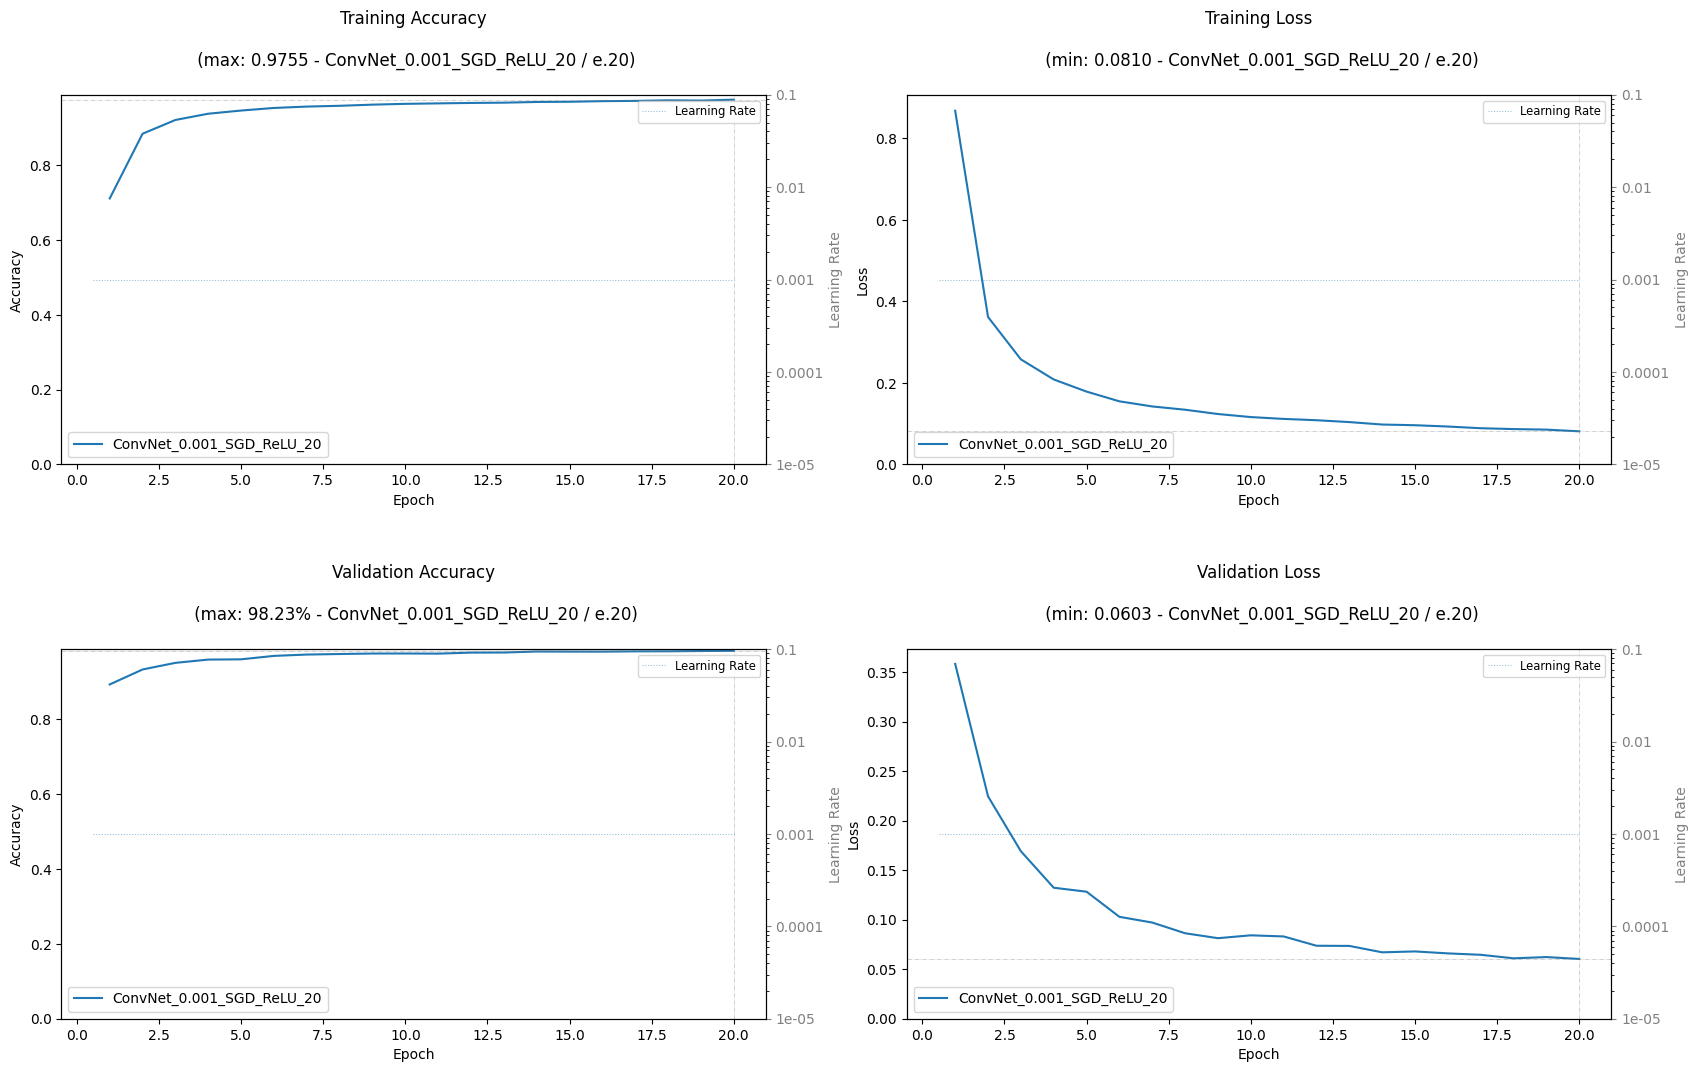

In [ ]:
plot_metrics()

# Extracting Features from ConvNet with learning rate of 1e-6 and 1 epoch

In [ ]:
model_list = [
    {"name": "ConvNet", "model": ConvNet},
]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model_features_1, model_labels_1 = extract_features(model_list, mount_point, project_folder, test_loader)

# Display the feature array
print("\nModel Features:")
print(model_features_1)

# Display the label array
print("\nModel Labels:")
print(model_labels_1)

Available models in a project folder:

1. ConvNet_acc0.9823_lr_1e-03_SGD_ReLU_epoch20.pth
2. ConvNet_acc0.1415_lr_1e-06_SGD_ReLU_epoch1.pth
3. ConvNet_acc0.9890_lr_1e-02_SGD_ReLU_epoch23.pth

Enter the number corresponding to the file you want to process: 2

Model Features:
[[0.         0.         0.         ... 0.0381168  0.0249872  0.01763055]
 [0.         0.         0.         ... 0.10305055 0.07657258 0.04233906]
 [0.         0.         0.         ... 0.02452955 0.02498333 0.01763055]
 ...
 [0.         0.         0.         ... 0.03917394 0.02498333 0.01763055]
 [0.         0.         0.         ... 0.05210875 0.03664431 0.01732067]
 [0.         0.         0.         ... 0.02452955 0.02498333 0.01763055]]

Model Labels:
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.031377
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.671082
[t-SNE] KL divergence after 1000 iterations: 0.764279


<ipython-input-37-b4d0c37f6bcc>:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_dict = {label: plt.cm.get_cmap(name=cmap)(i) for i, label in enumerate(class_names)}


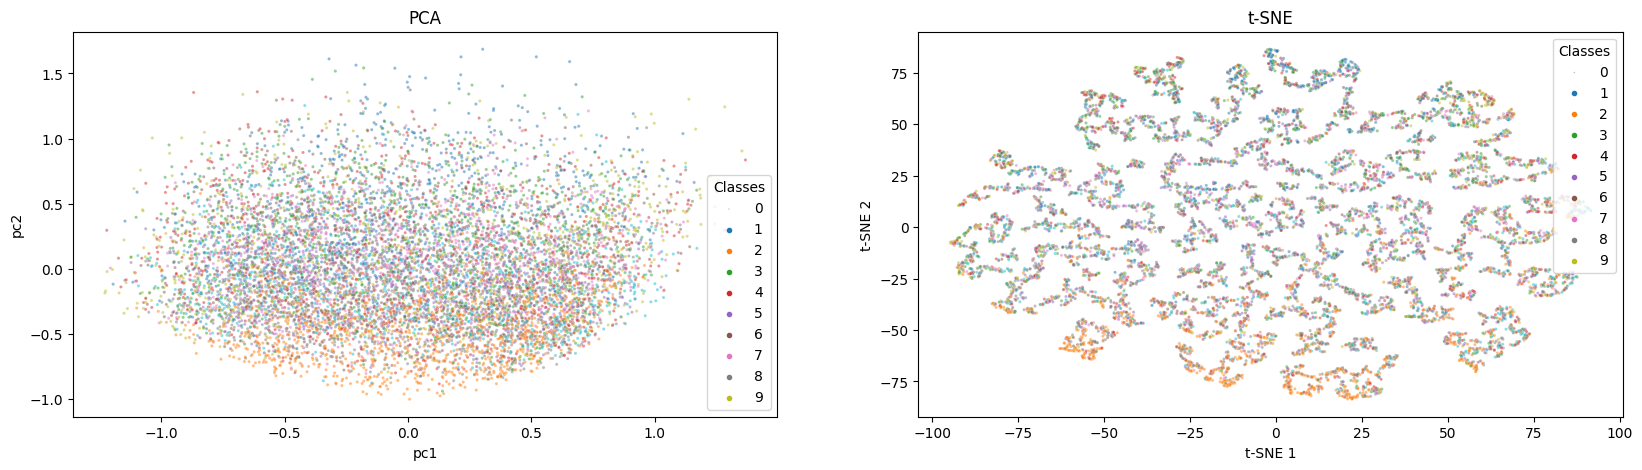

Time elapsed: 111.11600184440613 seconds


In [ ]:
time_start = time.time()

plot_pca_tsne_seaborn(model_features_1, model_labels_1, class_names, 1000, 1, 'tab10', 2, 2)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.193s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.337242
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.991638
[t-SNE] KL divergence after 1000 iterations: 2.172458


<ipython-input-37-b4d0c37f6bcc>:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_dict = {label: plt.cm.get_cmap(name=cmap)(i) for i, label in enumerate(class_names)}


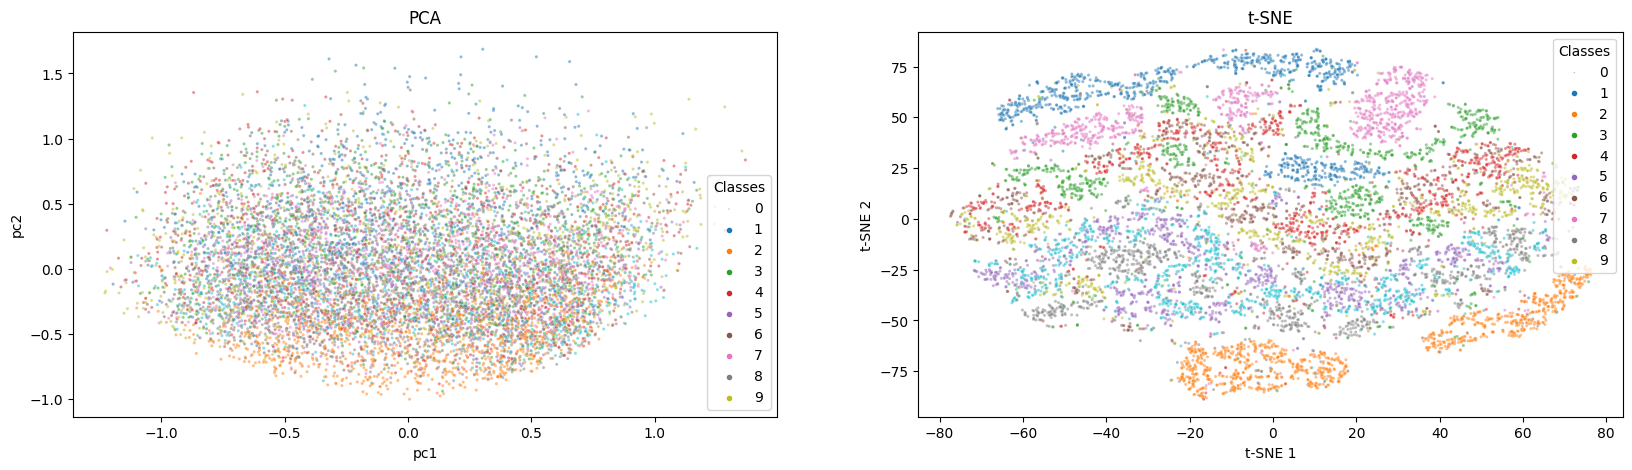

Time elapsed: 120.14222455024719 seconds


In [ ]:
time_start = time.time()

plot_pca_tsne_seaborn(model_features_1, model_labels_1, class_names, 1000, 1, 'tab10', 50, 2)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

# Extracting Features from ConvNet with learning rate of 1e-3 and 20 epoch

In [ ]:
model_features_2, model_labels_2 = extract_features(model_list, mount_point, project_folder, test_loader)

# Display the feature array
print("\nModel Features:")
print(model_features_2)

# Display the label array
print("\nModel Labels:")
print(model_labels_2)

Available models in a project folder:

1. ConvNet_acc0.9823_lr_1e-03_SGD_ReLU_epoch20.pth
2. ConvNet_acc0.1415_lr_1e-06_SGD_ReLU_epoch1.pth
3. ConvNet_acc0.9890_lr_1e-02_SGD_ReLU_epoch23.pth

Enter the number corresponding to the file you want to process: 1

Model Features:
[[0.01418448 0.01476261 0.         ... 0.00280538 0.00282523 0.00940357]
 [0.02247461 0.02591623 0.0256231  ... 0.08266678 0.08038283 0.08700225]
 [0.02247461 0.02470283 0.03340963 ... 0.00282523 0.00282523 0.00940357]
 ...
 [0.02247461 0.0256049  0.02726143 ... 0.00141893 0.00284993 0.00940357]
 [0.02247461 0.02591623 0.02591623 ... 0.03485599 0.00291221 0.00940357]
 [0.02130648 0.01633599 0.02203448 ... 0.00536603 0.00260635 0.00940749]]

Model Labels:
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.168s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.041281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.762894
[t-SNE] KL divergence after 1000 iterations: 0.772540


<ipython-input-37-b4d0c37f6bcc>:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_dict = {label: plt.cm.get_cmap(name=cmap)(i) for i, label in enumerate(class_names)}


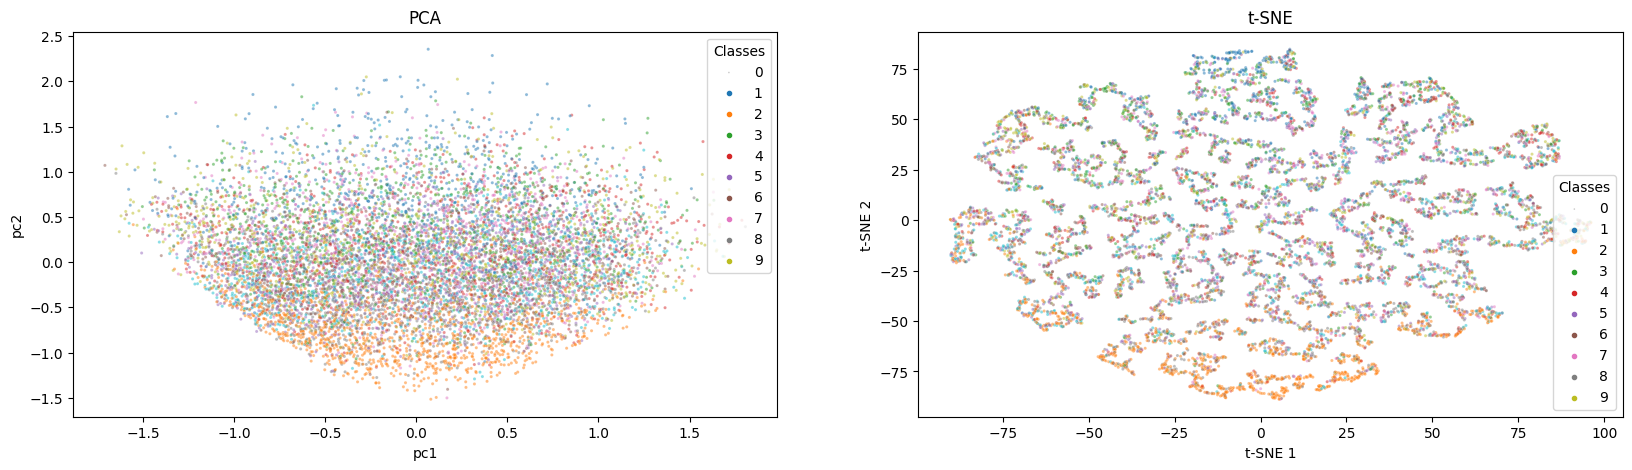

Time elapsed: 105.92296028137207 seconds


In [ ]:
time_start = time.time()

plot_pca_tsne_seaborn(model_features_2, model_labels_2, class_names, 1000, 1, 'tab10', 2, 2)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.468186
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.469582
[t-SNE] KL divergence after 1000 iterations: 2.165039


<ipython-input-37-b4d0c37f6bcc>:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_dict = {label: plt.cm.get_cmap(name=cmap)(i) for i, label in enumerate(class_names)}


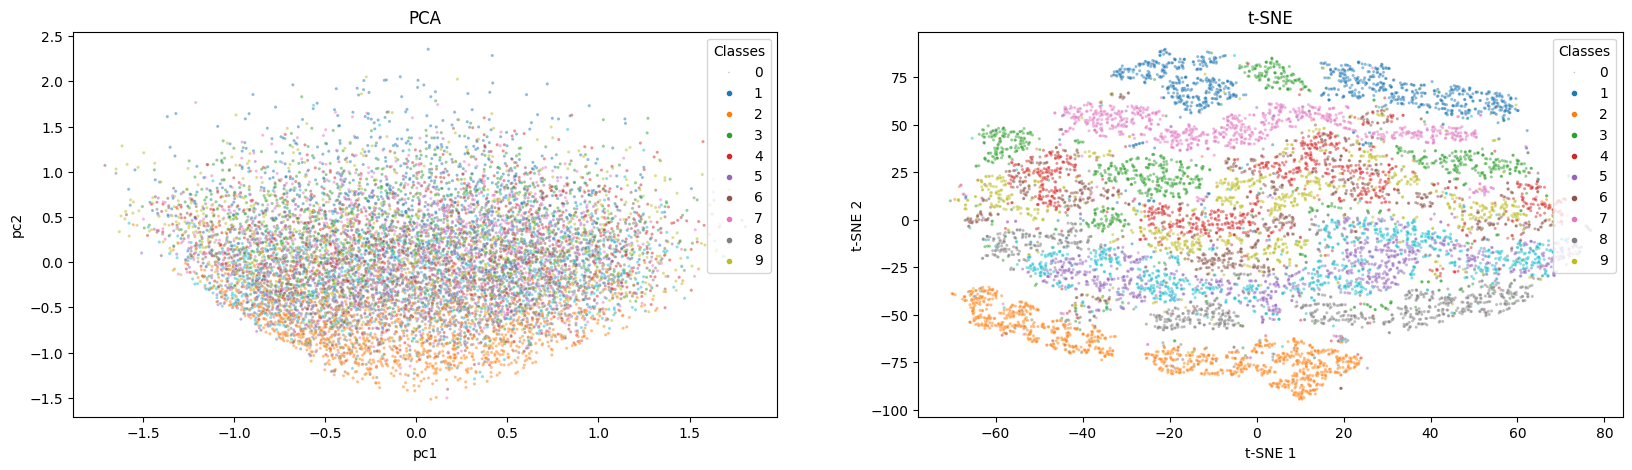

Time elapsed: 136.1156210899353 seconds


In [ ]:
time_start = time.time()

plot_pca_tsne_seaborn(model_features_2, model_labels_2, class_names, 1000, 1, 'tab10', 50, 2)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

# Extracting Features from ConvNet with learning rate of 1e-3 and 23 epoch

In [ ]:
model_features_3, model_labels_3 = extract_features(model_list, mount_point, project_folder, test_loader)

# Display the feature array
print("\nModel Features:")
print(model_features_3)

# Display the label array
print("\nModel Labels:")
print(model_labels_3)

Available models in a project folder:

1. ConvNet_acc0.9823_lr_1e-03_SGD_ReLU_epoch20.pth
2. ConvNet_acc0.1415_lr_1e-06_SGD_ReLU_epoch1.pth
3. ConvNet_acc0.9890_lr_1e-02_SGD_ReLU_epoch23.pth

Enter the number corresponding to the file you want to process: 3

Model Features:
[[0.00648288 0.01055111 0.00898027 ... 0.         0.         0.        ]
 [0.00648288 0.01055111 0.00872214 ... 0.         0.         0.        ]
 [0.00648288 0.01055111 0.00898027 ... 0.         0.         0.        ]
 ...
 [0.00648288 0.01055111 0.00898027 ... 0.         0.         0.        ]
 [0.00648288 0.01055111 0.00898027 ... 0.         0.         0.        ]
 [0.00648288 0.01055111 0.00890802 ... 0.         0.         0.        ]]

Model Labels:
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 0.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.036396
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.744713
[t-SNE] KL divergence after 3000 iterations: 0.720497


<ipython-input-37-b4d0c37f6bcc>:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_dict = {label: plt.cm.get_cmap(name=cmap)(i) for i, label in enumerate(class_names)}


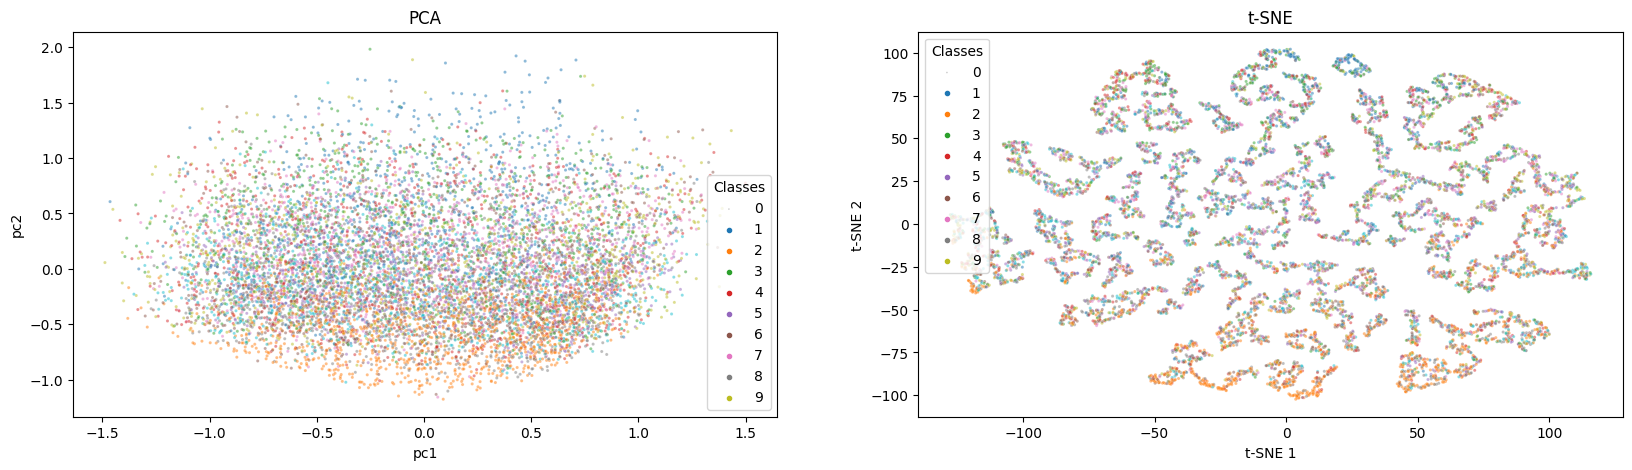

Time elapsed: 327.1054916381836 seconds


In [ ]:
time_start = time.time()

plot_pca_tsne_seaborn(model_features_3, model_labels_3, class_names, 3000, 1, 'tab10', 2, 2)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.202s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.420669
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.319923
[t-SNE] KL divergence after 1000 iterations: 2.179761


<ipython-input-37-b4d0c37f6bcc>:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_dict = {label: plt.cm.get_cmap(name=cmap)(i) for i, label in enumerate(class_names)}


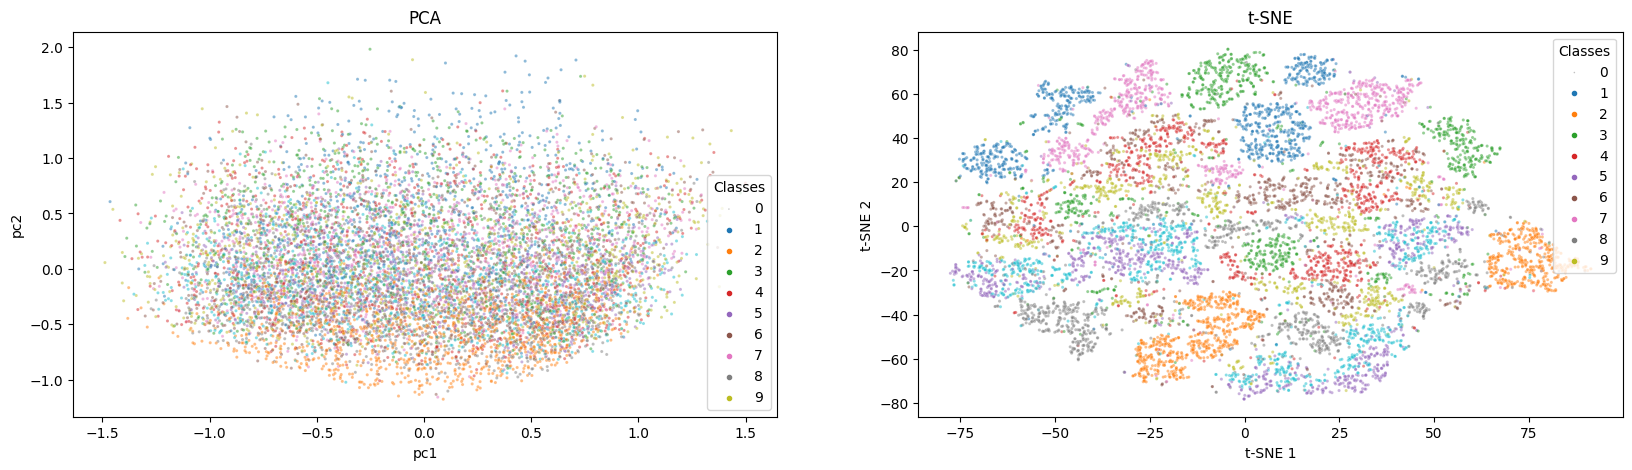

Time elapsed: 119.826406955719 seconds


In [ ]:
time_start = time.time()

plot_pca_tsne_seaborn(model_features_3, model_labels_3, class_names, 1000, 1, 'tab10', 50, 2)
print('Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.833s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.420642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.321930
[t-SNE] KL divergence after 3000 iterations: 2.115203


<ipython-input-37-b4d0c37f6bcc>:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_dict = {label: plt.cm.get_cmap(name=cmap)(i) for i, label in enumerate(class_names)}


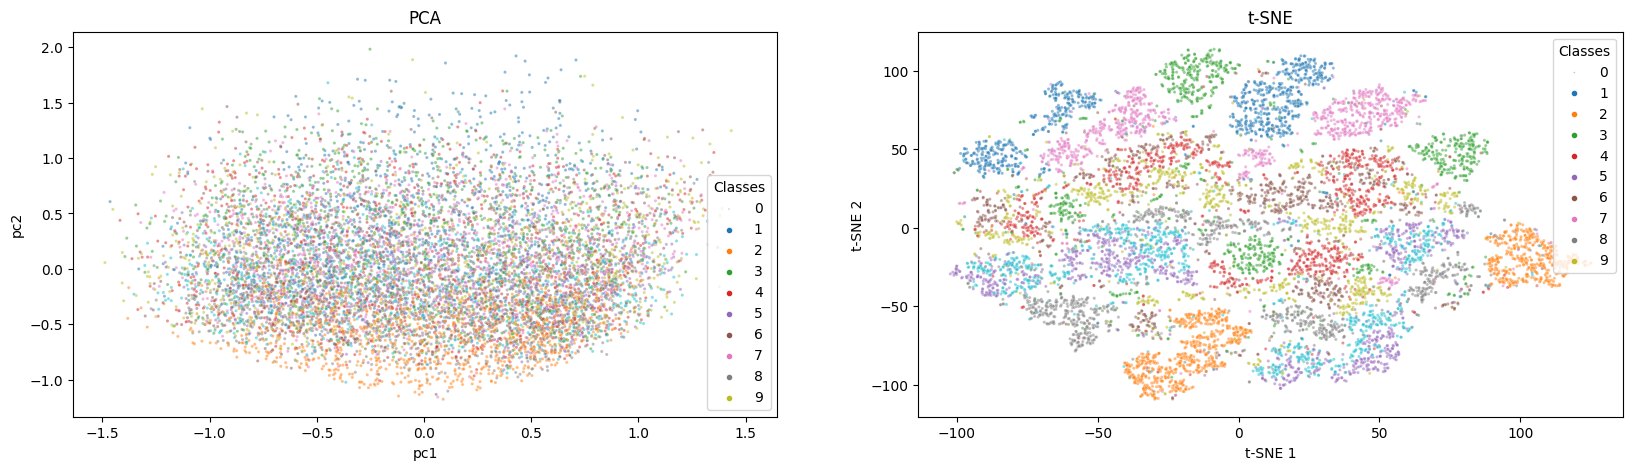

Time elapsed: 344.15324211120605 seconds


In [ ]:
time_start = time.time()
pca_components = 50

plot_pca_tsne_seaborn(model_features_3, model_labels_3, class_names, 3000, 1, 'tab10', 50, 2)
print('Time elapsed: {} seconds'.format(time.time()-time_start))